In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import pickle
import math

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
base_path = './drive/My Drive/Colab Notebooks/hw4/variational-autoencoder/'
train_path = base_path + 'hw4_tr7.pkl'
test_path = base_path + 'hw4_te7.pkl'

base_path_model = base_path + 'model/'

In [0]:
with open(train_path, 'rb') as f:
  train = pickle.load(f)

with open(test_path, 'rb') as f:
  test = pickle.load(f)

In [6]:
train.shape

(6265, 28, 28)

In [7]:
test.shape

(1028, 28, 28)

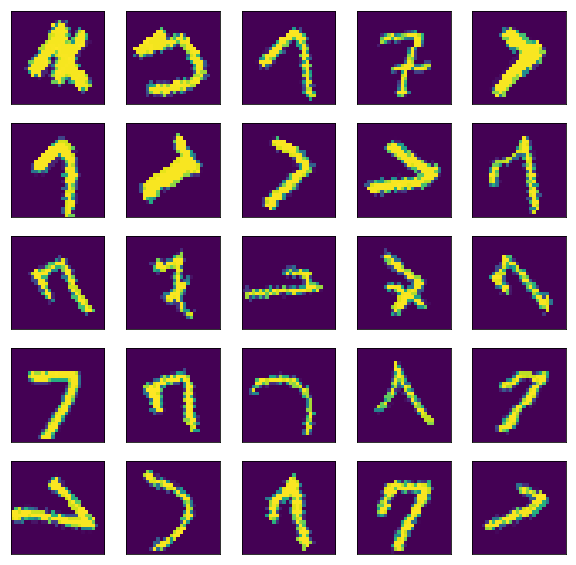

In [8]:
plt.figure(figsize=(10, 10))
for i in range(5):
  for j in range(5):
    ax = plt.subplot(5, 5, 5 * i + j + 1)
    plt.imshow(train[np.random.randint(0, train.shape[0])])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

In [0]:
X = tf.placeholder(dtype='float', shape=[None, 28, 28, 1], name='X')
Y = tf.placeholder(dtype='float', shape=[None, 28, 28, 1], name='Y')
Y_flat = tf.reshape(Y, [-1, 28*28])

n_gaussians = 5

In [0]:
def encoder(X):

  conv_1 = tf.layers.Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')(X)
  # pool_1 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_1)
  # bn_1 = tf.layers.BatchNormalization()(conv_1)

  conv_2 = tf.layers.Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')(conv_1)
  # pool_2 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
  # bn_2 = tf.layers.BatchNormalization()(conv_2)

  conv_3 = tf.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu, padding='same')(conv_2)
  # pool_3 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_3)
  # bn_3 = tf.layers.BatchNormalization()(conv_3)

  dropout_1 = tf.layers.Dropout(rate=0.4)(conv_3)

  flattened = tf.layers.Flatten()(dropout_1)
  dense_1 = tf.layers.Dense(units=n_gaussians * 2)(flattened)

  # use first half as mu
  mu = dense_1[:, :n_gaussians]

  # use 2nd half as std, standard deviation has to be positive
  std = tf.nn.softplus(dense_1[:, n_gaussians:])
  
  return mu, std

In [0]:
def decoder(z):
  dense_1 = tf.layers.Dense(units=512, activation=tf.nn.relu)(z)
  dense_2 = tf.layers.Dense(units=4 * 4 * 32, activation=tf.nn.relu)(dense_1)
  reshaped = tf.reshape(dense_2, [-1, 4, 4, 32])
  dconv_1 = tf.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu)(reshaped)
  dconv_2 = tf.layers.Conv2DTranspose(filters=32, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu)(dconv_1)
  flattened = tf.layers.Flatten()(dconv_2)
  dense_3 = tf.layers.Dense(units=28 * 28, activation=tf.nn.relu)(flattened)
  output = tf.reshape(dense_3, [-1, 28, 28, 1])
  return output, dense_3

In [12]:
mu, std = encoder(X)
z = mu + std * tf.random.normal(tf.shape(mu))
output, output_flat = decoder(z)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
mse = tf.reduce_sum(tf.squared_difference(output_flat, Y_flat), 1)

In [14]:
kld = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(std) - tf.log(1e-8 + tf.square(std)) - 1, 1)
loss = tf.reduce_mean(mse + kld)
optimizer = tf.train.AdamOptimizer(0.0004).minimize(loss)


Instructions for updating:
Use tf.cast instead.


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())